Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

1. Load StackOverflow datasets as dataframe
2. Extract and label the datasets for each task
3. Extract features for each task
4. Analyze features
5. Train models for each task with the features
6. Quantify the importance of each feature category

1. Load StackOverflow datasets as dataframe

In [4]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def store_df_at_google_drive(fname, df):
    s = io.StringIO()
    df.to_csv(s)
    uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
    uploaded.SetContentString(s.getvalue())
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
      if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
          print('  Load file: {}'.format(f['title']))
          f_ = gdrive.CreateFile({'id': f['id']})
          f_.GetContentFile(f['title'])
          files.append(f['title'])
    return files

In [9]:
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [10]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~ July 31, 2012

There are 2 tasks:

A. After a user's K-th post, predict how likely it is that the user will churn

B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [11]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

# You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]


posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K


def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]


def getTask1Users(users, posts, K):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [14]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [16]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


3. Extract features for each task

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()

In [0]:
# Temporal features 2: gapK

def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60

In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [22]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

K=1


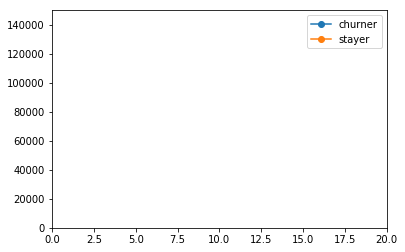

K=2


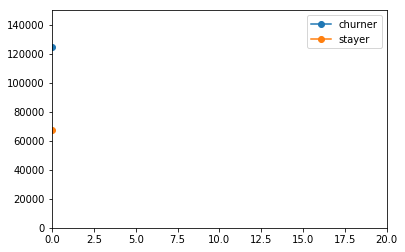

K=3


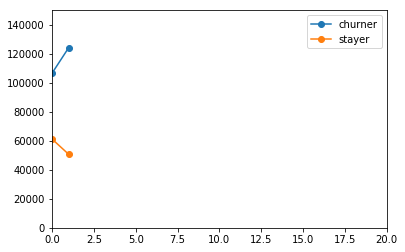

K=4


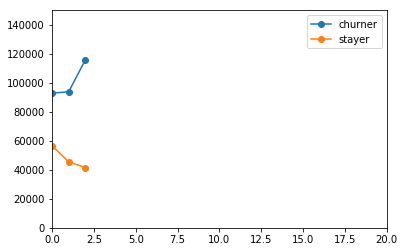

K=5


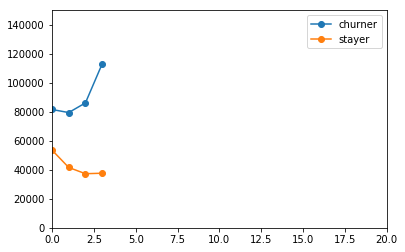

K=6


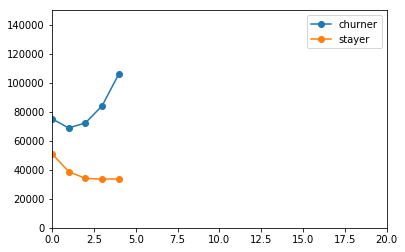

K=7


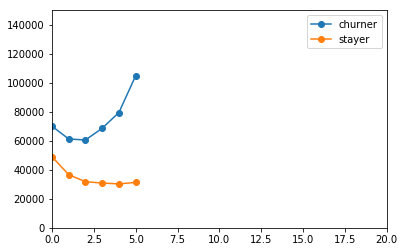

K=8


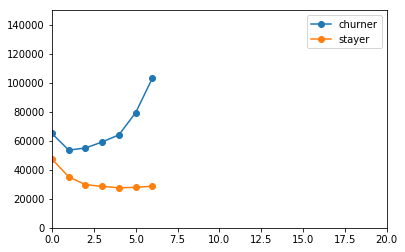

K=9


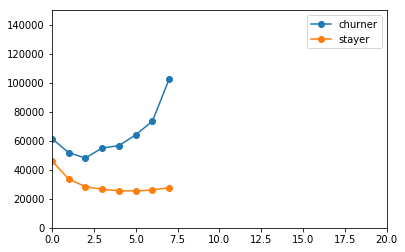

K=10


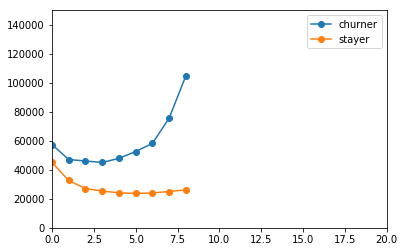

K=11


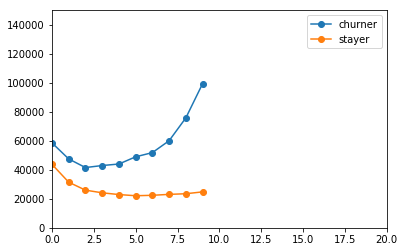

K=12


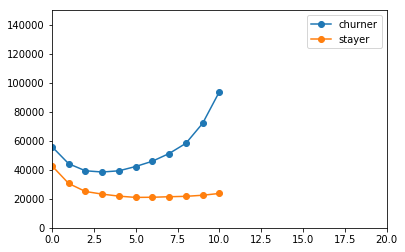

K=13


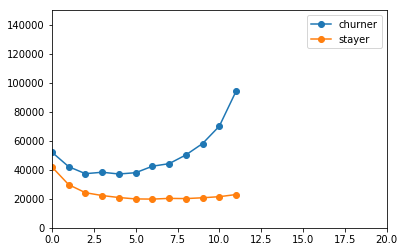

K=14


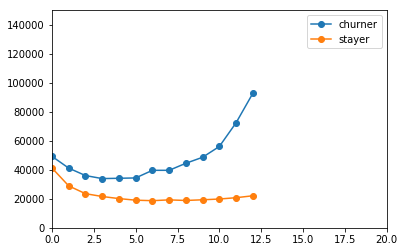

K=15


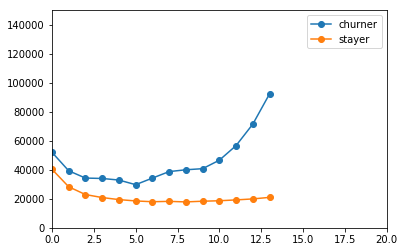

K=16


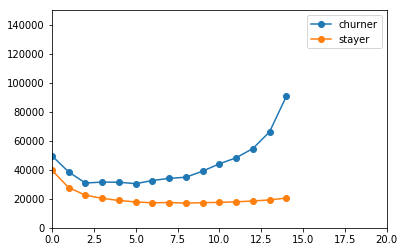

K=17


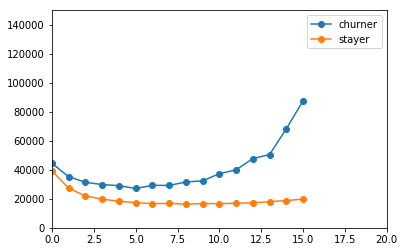

K=18


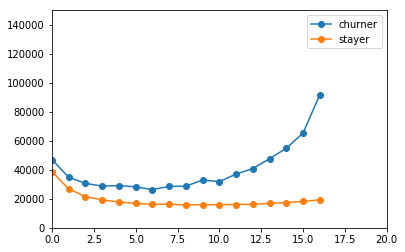

K=19


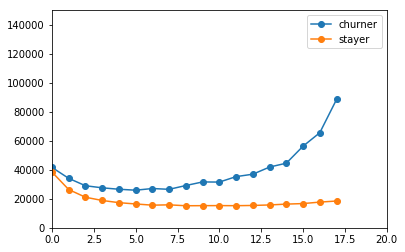

K=20


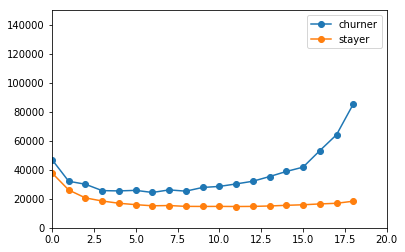

In [23]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

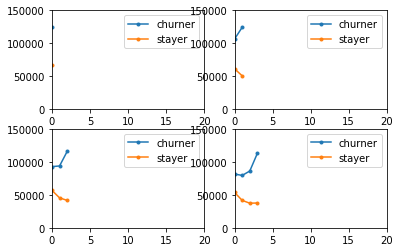

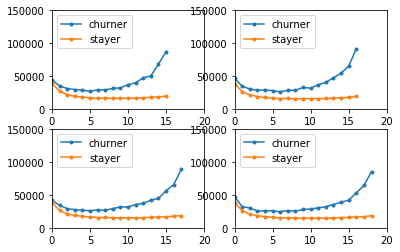

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, marker='.', label='churner')
    ax.plot(s, marker='.', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, marker='.', label='churner')
    ax.plot(s, marker='.', label='stayer')
    ax.legend(loc='upper left')
    ax.axis((0,20,0,15e4))
plt.show()

In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [29]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

# Answers vs Churn probability


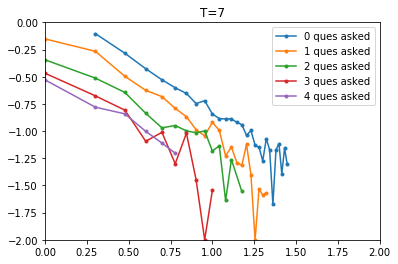

# Answers vs Churn probability


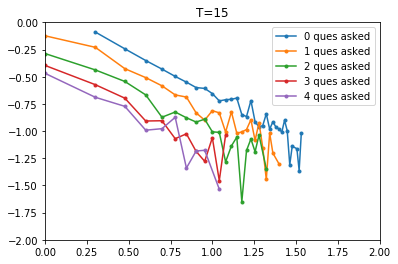

# Answers vs Churn probability


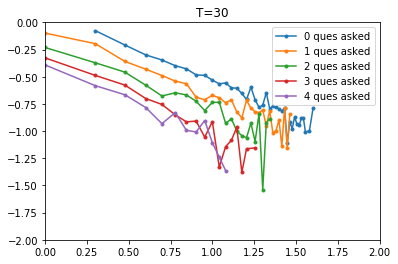

In [31]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 marker='.',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.title("T={}".format(str(T)))
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [42]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [43]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

Extract knowledge features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


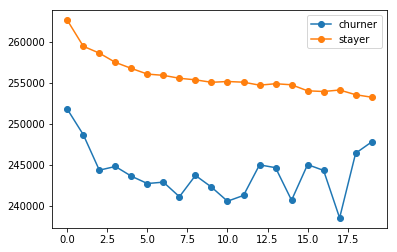

In [44]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] > 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

3-4. Speed features

In [0]:
# Speed features 1: answering_speed
def getAnsweringSpeed(posts):
    ret_df = pd.merge(
        posts[posts['PostTypeId']==2][['OwnerUserId', 'CreationDate', 'ParentId']],
        posts[posts['PostTypeId']==1][['CreationDate', 'Id']],
        left_on = 'ParentId',
        right_on = 'Id',
        how='left',
        suffixes=['_ans', '_ques']
    )
    ret_df['ans_delay'] = (ret_df['CreationDate_ans'] - ret_df['CreationDate_ques'])
    ret_df['answering_speed'] = ret_df['ans_delay'].apply(lambda x: np.nan if pd.isnull(x) else 1/(x.total_seconds()/3600 + 1e-07))
    return ret_df.groupby("OwnerUserId")['answering_speed'].mean()

3-5. Quality features

In [0]:
# Quality features 1: ans_score
# Quality features 2: que_score
def getScoreOfAnswers(posts):
    return posts[posts['PostTypeId']==2].groupby('OwnerUserId')['Score'].mean().rename("ans_score")

def getScoreOfQuestions(posts):
    return posts[posts['PostTypeId']==1].groupby('OwnerUserId')['Score'].mean().rename("que_score")

3-6. Consistency features

In [0]:
# Consistency features 1: ans_stddev
# Consistency features 2: que_stddev
def getStdevOfScoresOfAnswers(posts):
    return posts[posts['PostTypeId']==2].groupby('OwnerUserId')['Score'].std().rename("ans_stddev")

def getStdevOfScoresOfQuestions(posts):
    return posts[posts['PostTypeId']==1].groupby('OwnerUserId')['Score'].std().rename("que_stddev")

3-7. Gratitude features

In [0]:
# Gratitude features 1: ans_comments
# Gratitude features 2: que_comments
def getAvgNumOfAnswers(posts):
    return posts[posts['PostTypeId']==2].groupby("OwnerUserId")["CommentCount"].mean().rename("ans_comments")

def getAvgNumOfQuestions(posts):
    return posts[posts['PostTypeId']==1].groupby("OwnerUserId")["CommentCount"].mean().rename("que_comments")

3-8. Competitiveness features

In [0]:
# Competitiveness features 1: relative_rank_pos
def getRelRankPos(posts):
    ret_df = pd.merge(
        posts[posts['PostTypeId']==2][['OwnerUserId', 'ParentId', 'Score']],
        posts[posts['PostTypeId']==1][['Id', 'AnswerCount']],
        left_on='ParentId',
        right_on='Id',
        how='left'
    )
    ret_df ['Score_Rank'] = posts_df.groupby("ParentId")['Score'].rank(ascending=False).apply(int)
    
    ret_df['relative_rank_pos'] = ret_df['AnswerCount']/ret_df['Score_Rank']
    return ret_df.groupby('OwnerUserId')['relative_rank_pos'].mean()

3-9. Content features

In [0]:
# Content features 1: ans_length
# Content features 2: que_length
def getLengthOfAnswers(posts):
    return posts[posts['PostTypeId']==2].groupby('OwnerUserId')['BodyWordNum'].mean().rename('ans_length')

def getLengthOfQuestions(posts):
    return posts[posts['PostTypeId']==1].groupby('OwnerUserId')['BodyWordNum'].mean().rename('que_length')

In [51]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    
    features_of_task1[K]['answering_speed'] = getAnsweringSpeed(posts)
    features_of_task1[K]['ans_score'] = getScoreOfAnswers(posts)
    features_of_task1[K]['que_score'] = getScoreOfQuestions(posts)
    features_of_task1[K]['ans_stddev'] = getStdevOfScoresOfAnswers(posts)
    features_of_task1[K]['que_stddev'] = getStdevOfScoresOfAnswers(posts)
    features_of_task1[K]['ans_comments'] = getAvgNumOfAnswers(posts)
    features_of_task1[K]['que_comments'] = getAvgNumOfQuestions(posts)
    features_of_task1[K]['relative_rank_pos'] = getRelRankPos(posts)
    features_of_task1[K]['ans_length'] = getLengthOfAnswers(posts)
    features_of_task1[K]['que_length'] = getLengthOfQuestions(posts)

Extract knowledge features of task1(K= 1 )
Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [53]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]

    features_of_task2[T]['answering_speed'] = getAnsweringSpeed(posts)
    features_of_task2[T]['ans_score'] = getScoreOfAnswers(posts)
    features_of_task2[T]['que_score'] = getScoreOfQuestions(posts)
    features_of_task2[T]['ans_stddev'] = getStdevOfScoresOfAnswers(posts)
    features_of_task2[T]['que_stddev'] = getStdevOfScoresOfAnswers(posts)
    features_of_task2[T]['ans_comments'] = getAvgNumOfAnswers(posts)
    features_of_task2[T]['que_comments'] = getAvgNumOfQuestions(posts)
    features_of_task2[T]['relative_rank_pos'] = getRelRankPos(posts)
    features_of_task2[T]['ans_length'] = getLengthOfAnswers(posts)
    features_of_task2[T]['que_length'] = getLengthOfQuestions(posts)

Extract knowledge features of task2(T=) 7 )
Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


In [56]:
features_of_task1[20].count()

Reputation               74381
CreationDate             74381
LastAccessDate           74381
num_posts                74381
is_churn                 74381
gap1                     74381
gap2                     74381
gap3                     74381
gap4                     74381
gap5                     74381
gap6                     74381
gap7                     74381
gap8                     74381
gap9                     74381
gap10                    74381
gap11                    74381
gap12                    74381
gap13                    74381
gap14                    74381
gap15                    74381
gap16                    74381
gap17                    74381
gap18                    74381
gap19                    74381
gap20                    74381
num_answers              74381
num_questions            74381
ans_que_ratio            74381
accepted_answerer_rep        0
max_rep_answerer         46936
num_que_answered         61419
time_for_first_ans       40830
rep_ques

In [55]:
features_of_task2[30].count()

Reputation               471936
CreationDate             471936
LastAccessDate           471936
num_posts                471936
is_churn                 471936
gap1                     471936
last_gap                 471936
time_since_last_post     471936
mean_gap                 471936
num_answers              471936
num_questions            471936
ans_que_ratio            471936
accepted_answerer_rep         0
max_rep_answerer          33412
num_que_answered         328436
time_for_first_ans        32353
rep_questioner            26144
rep_answerers             33412
rep_co_answerers          26144
num_answers_recvd        335650
answering_speed          115722
ans_score                212097
que_score                335650
ans_stddev                74635
que_stddev                74635
ans_comments             212097
que_comments             335650
relative_rank_pos        115722
ans_length               212097
que_length               335650
dtype: int64

In [58]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
    store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))

Uploaded file with ID 1_uyZyz6MXU-f1vwuN0AyGDvMxCHO2lXG
Uploaded file with ID 1JIJtIo4ozn4U5cqFGw9STsQ7sDu8i_jQ
Uploaded file with ID 1j9C_JXSe3DRW4a-IOIoDACvu7Tp6T_Dv
Uploaded file with ID 1VU1As5_DvRJq_8TmNNHPXUbToaZooByo
Uploaded file with ID 1B7Oj7IxCmvuQzY42wtmsdoJ_GuxeInY_
Uploaded file with ID 10LFDK34XuA_h6z6aT-NmQJDW2pFBdhHK
Uploaded file with ID 1aNboNm_pfbj2tf0YtTYjIx2fIVqCoiiN
Uploaded file with ID 1Ukg5sLNBHSj5b5cRKpbdvfKMaewZQf8T
Uploaded file with ID 1qD2kFBD2rELozuiTBBHOtiyyRAa_50N0
Uploaded file with ID 1ZaV7i8iyk0hkwXvl2Du_GF9fiDnaliV0
Uploaded file with ID 1wRKKpVZvy9AwJnCNlcV5YXIbany2vXKw
Uploaded file with ID 1jSrlbRNY1xGr5gnTA5-C9t3d_u04OCan
Uploaded file with ID 1DidgFTuRT-BBgH-S8QSgv57yPGw673gi
Uploaded file with ID 1WgAMmYGfKBrko3U1iXoJdF67fvNvm3Bp
Uploaded file with ID 10tDTnui9AOQn_f5vlo9qB9WBKbfbdyV5
Uploaded file with ID 1A8GYnyKEcc-qvzTM4yl6Pv9vuFoCVZrg
Uploaded file with ID 14rs7krf53QwG5xBhQL9vHSONXIixCAdG
Uploaded file with ID 1_o0-0LP9_6M97v8T1XZrzxSv5

In [59]:
for T in list_of_T:
    store_df_at_google_drive('task2_{}posts_features.csv'.format(T), features_of_task2[T])
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))

Uploaded file with ID 1f7VlxrDsxkVfeFhsYqKEKjffHj2CRhBi
Uploaded file with ID 1mVmao5f0JsfN3zPzEUC01QkNGk2xmAHl
Uploaded file with ID 1AjAWlI11QTvgZMtKd8teCc17r60qOp6v


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression

In [0]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0,
        'answering_speed' : 0,
        'ans_score' : 0,
        'que_score' : 0,
        'ans_stddev' : 0,
        'que_stddev' : 0,
        'ans_comments' : 0,
        'que_comments' : 0,
        'relative_rank_pos' : 0,
        'ans_length' : 0,
        'que_length' : 0
    }
    return features.fillna(fill_constants)
                                                                         

In [0]:
#Under Sampling
def under_samping(features):
    nChurn = len(features[features['is_churn']==1])
    nStay = len(features[features['is_churn']==0])
    
    minN = min(nChurn, nStay)
    if nChurn > minN:
        churnIndex = np.random.choice(nChurn, minN, replace=False)
    else:
        churnIndex = np.arange(minN)
        
    if nStay > minN:
        stayIndex = np.random.choice(nStay, minN, replace=False)
    else:
        stayIndex = np.arange(minN)

    return pd.concat([
        (features[features['is_churn']==1].reset_index()).loc[churnIndex],
        (features[features['is_churn']==0].reset_index()).loc[stayIndex]
    ]).reset_index(drop=True)

In [62]:
for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = under_samping(fill_nan(features_of_task1[K]))


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )


In [63]:
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = under_samping(fill_nan(features_of_task2[T]))


Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [0]:
# Prerequisite for using thundersvm,

# CUDA 버전을 9.0으로 맞춰 줍니다.

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

In [69]:
# Confirm that CUDA version is 9.0
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [70]:
# Install thundersvm module
!pip3 install thundersvm

     |████████████████████████████████| 501kB 2.7MB/s 


In [71]:
# Installation for comparison / visualization
!pip3 install numpy matplotlib scikit-learn

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=30000, centers=2,
                  random_state=0, cluster_std=0.60)

In [0]:
# Visualization function
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
       levels=[-1, 0, 1], alpha=0.5,
       linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
           model.support_vectors_[:, 1],
           s=300, linewidth=1, facecolors='none');
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


elapsed: 15.603474617004395


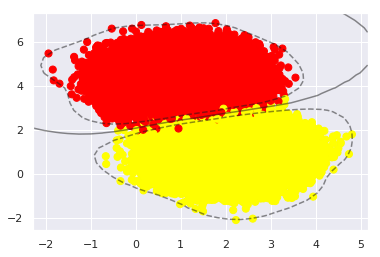

In [74]:
# Performance of SVM in Scikit-learn
from sklearn.svm import SVC # \"Support vector classifier\"
from time import time
start_time = time()
model = SVC()
model.fit(X, y)
print("elapsed: {}".format(time() - start_time))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [0]:
from thundersvm import SVC
from time import time
start_time = time()
model = SVC()
model.fit(X, y)
print("elapsed: {}".format(time() - start_time))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e3
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

  

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        mdl = model().fit(X_train, y_train)
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
model = DecisionTreeClassifier

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


In [0]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
model = DecisionTreeClassifier

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
}

In [0]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temoral':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            features_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    plt.show()


In [0]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category

In [0]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [0]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap

In [0]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)